In [141]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
import plotly.express as px

In [142]:
# read in data and subset for desired features 
dogs_df = pd.read_csv('dogs (3).csv')
dogs_df = dogs_df[['id', 'delta_time_minutes', 'age', 'gender', 'size', 'coat', 'primary_breed', 'primary_color', 'compatible_children', 'compatible_dogs', 'compatible_cats']]

# drop null values and reset index
dogs_df.dropna(inplace=True)
dogs_df.reset_index()
dogs_df

,id,delta_time_minutes,age,gender,size,coat,primary_breed,primary_color,compatible_children,compatible_dogs,compatible_cats
0,59313263,1213.833333,Adult,Male,Small,Short,Chihuahua,Yellow / Tan / Blond / Fawn,True,True,True
2,59313253,733.033333,Young,Male,Medium,Medium,Shetland Sheepdog / Sheltie,Merle (Blue),False,True,True
8,59313185,1269.450000,Young,Female,Large,Short,Anatolian Shepherd,Bicolor,True,True,True
10,59263354,1127.616667,Baby,Female,Medium,Short,Coonhound,Black,True,True,True
11,59313109,119.766667,Young,Male,Medium,Short,Beagle,"Tricolor (Brown, Black, & White)",True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
4923,59262866,23.766667,Young,Female,Medium,Short,Pit Bull Terrier,Black,True,True,True
4927,59262859,872.433333,Young,Male,Medium,Long,Goldendoodle,Golden,True,True,True
4930,59262849,1288.566667,Baby,Female,Medium,Medium,German Shepherd Dog,Black,True,True,False
4931,59262848,1272.966667,Senior,Male,Large,Short,Black Labrador Retriever,Black,True,True,True


In [144]:
# make dummy columns 
dogs_df_dummies = pd.get_dummies(data=dogs_df, 
                                 columns=['age', 'gender', 'size', 'coat', 'primary_breed','primary_color'])

In [153]:
def random_forest_regress_default(x_feat_list, y_col, df): 
    """takes in dataframe and list of x features used to build random forest regressor predicting y column
    
        Args: 
            x_feat_list 
            
        Returns: 
            feat_importance_dict (dictionary)
            feat_importances (list)
    """

    # split into x and y data
    X = df.loc[:, x_feat_list].values
    y = df.loc[:, y_col].values

    # split into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # initialize random forest regressor 
    regressor = RandomForestRegressor()

    # fit random forest regressor
    regressor.fit(X_train, y_train)

    # predict using regressor 
    y_pred = regressor.predict(X_test)
    
    # calculate accuracy scores 
    # oob_score = regressor.oob_score_
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # build dictionary of features and their importance to the model 
    feat_importances = regressor.feature_importances_
    feat_import_dict = {}
    for index, item in enumerate(feat_importances):
        feat = x_feat_list[index]
        feat_import_dict[feat] = item 
    
    # sort dictionary in descending order 
    sorted_feat_import_dict = sorted(feat_import_dict.items(), key=lambda x:x[1], reverse=True)
    converted_dict = dict(sorted_feat_import_dict)
    
    residuals = y_test - y_pred
    
    return feat_importances, converted_dict, r2, mse, residuals

In [154]:
def random_forest_regress(x_feat_list, y_col, df): 
    """takes in dataframe and list of x features used to build random forest regressor predicting y column
    
        Args: 
            x_feat_list 
            
        Returns: 
            feat_importance_dict (dictionary)
            feat_importances (list)
    """

    # split into x and y data
    X = df.loc[:, x_feat_list].values
    y = df.loc[:, y_col].values

    # split into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # initialize random forest regressor 
    regressor = RandomForestRegressor(n_estimators=100, 
                                     bootstrap=True, oob_score=True, random_state=42)

    # fit random forest regressor
    regressor.fit(X_train, y_train)

    # predict using regressor 
    y_pred = regressor.predict(X_test)
    
    # calculate accuracy scores 
    # oob_score = regressor.oob_score_
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # build dictionary of features and their importance to the model 
    feat_importances = regressor.feature_importances_
    feat_import_dict = {}
    for index, item in enumerate(feat_importances):
        feat = x_feat_list[index]
        feat_import_dict[feat] = item 
    
    # sort dictionary in descending order 
    sorted_feat_import_dict = sorted(feat_import_dict.items(), key=lambda x:x[1], reverse=True)
    converted_dict = dict(sorted_feat_import_dict)
    
    residuals = y_test - y_pred
    
    return feat_importances, converted_dict, r2, mse, oob_score, residuals

In [155]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ TAKEN FROM PROF MATT HIGGER FALL 2022 DS2500
        plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')


### Test 1a: All X Features
Using original regressor function (has more arguments to random forest regressor init)

In [156]:
# use all x features and run first random forest regression 
x_feat_list = ['compatible_children', 'compatible_dogs', 'compatible_cats', 
               'age_Adult', 'age_Baby', 'age_Senior', 'age_Young', 'gender_Female', 'gender_Male', 
               'size_Extra Large', 'size_Large', 'size_Medium', 'size_Small', 'coat_Curly', 'coat_Hairless', 
               'coat_Long', 'coat_Medium', 'coat_Short', 'coat_Wire', 'primary_breed_Affenpinscher', 
               'primary_breed_Alaskan Malamute', 'primary_breed_American Bulldog', 
               'primary_breed_American Bully', 'primary_breed_American Eskimo Dog', 
               'primary_breed_American Staffordshire Terrier', 'primary_breed_Anatolian Shepherd', 
               'primary_breed_Aussiedoodle', 'primary_breed_Australian Cattle Dog / Blue Heeler', 
               'primary_breed_Australian Kelpie', 'primary_breed_Australian Shepherd', 
               'primary_breed_Australian Terrier', 'primary_breed_Basset Hound', 'primary_breed_Beagle', 
               'primary_breed_Belgian Shepherd / Malinois', 'primary_breed_Bernese Mountain Dog', 
               'primary_breed_Bichon Frise', 'primary_breed_Black Labrador Retriever', 
               'primary_breed_Black Mouth Cur', 'primary_breed_Bloodhound', 'primary_breed_Blue Lacy', 
               'primary_breed_Border Collie', 'primary_breed_Border Terrier', 'primary_breed_Boston Terrier', 
               'primary_breed_Boxer', 'primary_breed_Brussels Griffon', 'primary_breed_Cairn Terrier', 
               'primary_breed_Carolina Dog', 'primary_breed_Catahoula Leopard Dog', 'primary_breed_Cattle Dog', 
               'primary_breed_Cavalier King Charles Spaniel', 'primary_breed_Chihuahua', 
               'primary_breed_Chinese Crested Dog', 'primary_breed_Chiweenie', 'primary_breed_Chocolate Labrador Retriever', 
               'primary_breed_Chow Chow', 'primary_breed_Cocker Spaniel', 'primary_breed_Collie', 'primary_breed_Coonhound', 
               'primary_breed_Corgi', 'primary_breed_Dachshund', 'primary_breed_Dalmatian', 
               'primary_breed_Doberman Pinscher', 'primary_breed_Dogo Argentino', 'primary_breed_Dutch Shepherd', 
               'primary_breed_English Bulldog', 'primary_breed_English Coonhound', 'primary_breed_English Setter', 
               'primary_breed_English Shepherd', 'primary_breed_Entlebucher', 'primary_breed_Feist', 
               'primary_breed_Flat-Coated Retriever', 'primary_breed_Fox Terrier', 'primary_breed_Foxhound', 
               'primary_breed_French Bulldog', 'primary_breed_German Shepherd Dog', 'primary_breed_German Wirehaired Pointer', 
               'primary_breed_Golden Retriever', 'primary_breed_Goldendoodle', 'primary_breed_Great Dane', 
               'primary_breed_Great Pyrenees', 'primary_breed_Greyhound', 'primary_breed_Hound', 'primary_breed_Husky', 
               'primary_breed_Ibizan Hound', 'primary_breed_Icelandic Sheepdog', 'primary_breed_Irish Terrier', 
               'primary_breed_Italian Greyhound', 'primary_breed_Jack Russell Terrier', 'primary_breed_Japanese Chin', 
               'primary_breed_Labradoodle', 'primary_breed_Labrador Retriever', 'primary_breed_Lhasa Apso', 
               'primary_breed_Maltese', 'primary_breed_Maltipoo', 'primary_breed_Mastiff', 'primary_breed_Miniature Dachshund', 
               'primary_breed_Miniature Pinscher', 'primary_breed_Miniature Poodle', 'primary_breed_Miniature Schnauzer', 
               'primary_breed_Mixed Breed', 'primary_breed_Mountain Cur', 'primary_breed_Newfoundland Dog', 
               'primary_breed_Norfolk Terrier', 'primary_breed_Old English Sheepdog', 'primary_breed_Parson Russell Terrier', 
               'primary_breed_Patterdale Terrier / Fell Terrier', 'primary_breed_Pekingese', 'primary_breed_Pharaoh Hound', 
               'primary_breed_Pit Bull Terrier', 'primary_breed_Pointer', 'primary_breed_Pomeranian', 'primary_breed_Poodle', 
               'primary_breed_Pug', 'primary_breed_Rat Terrier', 'primary_breed_Retriever', 'primary_breed_Rhodesian Ridgeback', 
               'primary_breed_Rottweiler', 'primary_breed_Saluki', 'primary_breed_Schnauzer', 'primary_breed_Shar-Pei', 
               'primary_breed_Shepherd', 'primary_breed_Shetland Sheepdog / Sheltie', 'primary_breed_Shiba Inu', 
               'primary_breed_Shih Tzu', 'primary_breed_Siberian Husky', 'primary_breed_Spaniel', 
               'primary_breed_Staffordshire Bull Terrier', 'primary_breed_Standard Poodle', 'primary_breed_Terrier', 
               'primary_breed_Tibetan Terrier', 'primary_breed_Vizsla', 'primary_breed_Weimaraner', 'primary_breed_Whippet', 
               'primary_breed_White German Shepherd', 'primary_breed_Wirehaired Terrier', 'primary_breed_Xoloitzcuintli / Mexican Hairless', 
               'primary_breed_Yellow Labrador Retriever', 'primary_breed_Yorkshire Terrier', 'primary_color_Apricot / Beige', 
               'primary_color_Bicolor', 'primary_color_Black', 'primary_color_Brindle', 'primary_color_Brown / Chocolate', 
               'primary_color_Golden', 'primary_color_Gray / Blue / Silver', 'primary_color_Harlequin', 
               'primary_color_Merle (Blue)', 'primary_color_Merle (Red)', 'primary_color_Red / Chestnut / Orange', 
               'primary_color_Sable', 'primary_color_Tricolor (Brown, Black, & White)', 'primary_color_White / Cream', 
               'primary_color_Yellow / Tan / Blond / Fawn']

feature_importances, feat_import_dict, r2, mse, oob_score, residuals  = random_forest_regress(x_feat_list=x_feat_list, y_col='delta_time_minutes', df=dogs_df_dummies)

In [157]:
print(feat_import_dict)

{'age_Baby': 0.030174291595549567, 'primary_color_Black': 0.029507921887994934, 'gender_Female': 0.025633660779341278, 'gender_Male': 0.02525875060855213, 'size_Medium': 0.02479455873071254, 'age_Adult': 0.02395360426843699, 'primary_breed_Labrador Retriever': 0.02314575259931015, 'primary_color_Tricolor (Brown, Black, & White)': 0.023077156670755182, 'coat_Medium': 0.023010828057869283, 'primary_color_White / Cream': 0.022247350833125262, 'compatible_cats': 0.021746292527822644, 'age_Young': 0.021450474868300793, 'size_Large': 0.01998819511526786, 'coat_Short': 0.019846155419057064, 'primary_color_Brown / Chocolate': 0.01901003745215802, 'primary_breed_Chihuahua': 0.018517467124394033, 'primary_breed_Mixed Breed': 0.018344261437611937, 'primary_color_Red / Chestnut / Orange': 0.01827270966180248, 'primary_color_Yellow / Tan / Blond / Fawn': 0.018177205889280533, 'size_Small': 0.016790374383240544, 'primary_color_Apricot / Beige': 0.01630402666204196, 'primary_breed_Terrier': 0.0161428

In [151]:
print(f'''For original random forest regressor function:\nOOB Score: {oob_score}, R2: {r2}, MSE: {mse}''')

For original random forest regressor function:
OOB Score: 0.9999825662336511, R2: -0.14361363071107403, MSE: 266444.4669252232


### Test 1b: All X Features
Using default regressor function (has default arguments to random forest regressor inititalization)
- Note that Default regressor function is used for the rest of this analysis as it yields better accuracy metrics

In [160]:
feature_importances, feat_import_dict, r2, mse, residuals  = random_forest_regress_default(x_feat_list=x_feat_list, y_col='delta_time_minutes', df=dogs_df_dummies)
print(f'''For default random forest regressor function:\nR2: {r2}, MSE: {mse}''')

For default random forest regressor function:
R2: -0.1533052002677946, MSE: 268702.45425141795


In [161]:
print(feat_import_dict)

{'age_Baby': 0.029762544059325043, 'primary_color_Black': 0.02901946248114368, 'gender_Male': 0.025676203050324184, 'gender_Female': 0.025196118543783248, 'primary_color_White / Cream': 0.025074966019324754, 'age_Young': 0.023956643270505444, 'age_Adult': 0.023726798451423017, 'primary_breed_Labrador Retriever': 0.02310954655641153, 'primary_color_Tricolor (Brown, Black, & White)': 0.022982956147290384, 'compatible_cats': 0.02218871917523529, 'coat_Medium': 0.021875770032996185, 'size_Medium': 0.02172707831621101, 'size_Large': 0.020407102074221674, 'primary_breed_Chihuahua': 0.019805752875434478, 'coat_Short': 0.019644070882607417, 'primary_breed_Australian Shepherd': 0.019427260806922454, 'primary_breed_Mixed Breed': 0.01907527635540406, 'primary_color_Yellow / Tan / Blond / Fawn': 0.018826610464795855, 'primary_color_Brown / Chocolate': 0.01877537983457138, 'primary_color_Red / Chestnut / Orange': 0.017776739633415927, 'size_Small': 0.016771899768455726, 'primary_breed_Corgi': 0.016

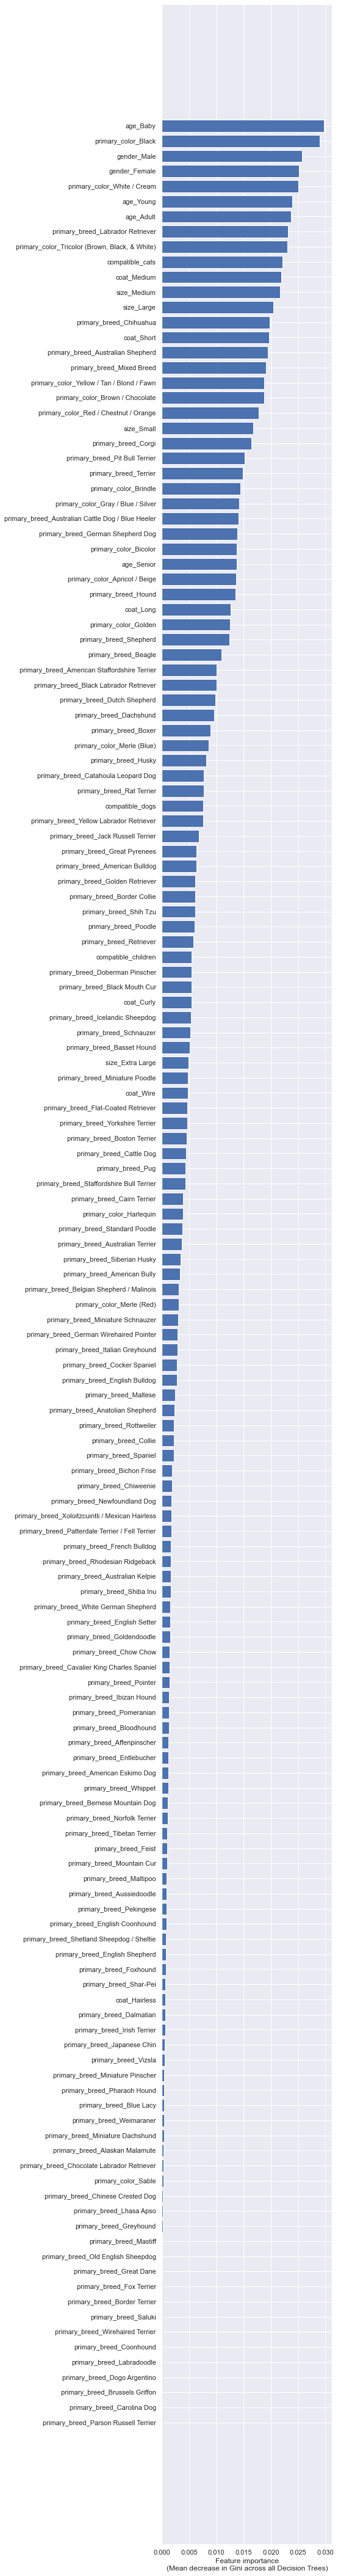

In [162]:
sns.set()
plot_feat_import(x_feat_list, feature_importances)

In [163]:
px.bar(x=x_feat_list, y=feature_importances).update_xaxes(categoryorder='total descending')

### Test 2: X Data only looking at Breeds 

In [164]:
x_feat_list_breeds = ['primary_breed_Affenpinscher', 
               'primary_breed_Alaskan Malamute', 'primary_breed_American Bulldog', 
               'primary_breed_American Bully', 'primary_breed_American Eskimo Dog', 
               'primary_breed_American Staffordshire Terrier', 'primary_breed_Anatolian Shepherd', 
               'primary_breed_Aussiedoodle', 'primary_breed_Australian Cattle Dog / Blue Heeler', 
               'primary_breed_Australian Kelpie', 'primary_breed_Australian Shepherd', 
               'primary_breed_Australian Terrier', 'primary_breed_Basset Hound', 'primary_breed_Beagle', 
               'primary_breed_Belgian Shepherd / Malinois', 'primary_breed_Bernese Mountain Dog', 
               'primary_breed_Bichon Frise', 'primary_breed_Black Labrador Retriever', 
               'primary_breed_Black Mouth Cur', 'primary_breed_Bloodhound', 'primary_breed_Blue Lacy', 
               'primary_breed_Border Collie', 'primary_breed_Border Terrier', 'primary_breed_Boston Terrier', 
               'primary_breed_Boxer', 'primary_breed_Brussels Griffon', 'primary_breed_Cairn Terrier', 
               'primary_breed_Carolina Dog', 'primary_breed_Catahoula Leopard Dog', 'primary_breed_Cattle Dog', 
               'primary_breed_Cavalier King Charles Spaniel', 'primary_breed_Chihuahua', 
               'primary_breed_Chinese Crested Dog', 'primary_breed_Chiweenie', 'primary_breed_Chocolate Labrador Retriever', 
               'primary_breed_Chow Chow', 'primary_breed_Cocker Spaniel', 'primary_breed_Collie', 'primary_breed_Coonhound', 
               'primary_breed_Corgi', 'primary_breed_Dachshund', 'primary_breed_Dalmatian', 
               'primary_breed_Doberman Pinscher', 'primary_breed_Dogo Argentino', 'primary_breed_Dutch Shepherd', 
               'primary_breed_English Bulldog', 'primary_breed_English Coonhound', 'primary_breed_English Setter', 
               'primary_breed_English Shepherd', 'primary_breed_Entlebucher', 'primary_breed_Feist', 
               'primary_breed_Flat-Coated Retriever', 'primary_breed_Fox Terrier', 'primary_breed_Foxhound', 
               'primary_breed_French Bulldog', 'primary_breed_German Shepherd Dog', 'primary_breed_German Wirehaired Pointer', 
               'primary_breed_Golden Retriever', 'primary_breed_Goldendoodle', 'primary_breed_Great Dane', 
               'primary_breed_Great Pyrenees', 'primary_breed_Greyhound', 'primary_breed_Hound', 'primary_breed_Husky', 
               'primary_breed_Ibizan Hound', 'primary_breed_Icelandic Sheepdog', 'primary_breed_Irish Terrier', 
               'primary_breed_Italian Greyhound', 'primary_breed_Jack Russell Terrier', 'primary_breed_Japanese Chin', 
               'primary_breed_Labradoodle', 'primary_breed_Labrador Retriever', 'primary_breed_Lhasa Apso', 
               'primary_breed_Maltese', 'primary_breed_Maltipoo', 'primary_breed_Mastiff', 'primary_breed_Miniature Dachshund', 
               'primary_breed_Miniature Pinscher', 'primary_breed_Miniature Poodle', 'primary_breed_Miniature Schnauzer', 
               'primary_breed_Mixed Breed', 'primary_breed_Mountain Cur', 'primary_breed_Newfoundland Dog', 
               'primary_breed_Norfolk Terrier', 'primary_breed_Old English Sheepdog', 'primary_breed_Parson Russell Terrier', 
               'primary_breed_Patterdale Terrier / Fell Terrier', 'primary_breed_Pekingese', 'primary_breed_Pharaoh Hound', 
               'primary_breed_Pit Bull Terrier', 'primary_breed_Pointer', 'primary_breed_Pomeranian', 'primary_breed_Poodle', 
               'primary_breed_Pug', 'primary_breed_Rat Terrier', 'primary_breed_Retriever', 'primary_breed_Rhodesian Ridgeback', 
               'primary_breed_Rottweiler', 'primary_breed_Saluki', 'primary_breed_Schnauzer', 'primary_breed_Shar-Pei', 
               'primary_breed_Shepherd', 'primary_breed_Shetland Sheepdog / Sheltie', 'primary_breed_Shiba Inu', 
               'primary_breed_Shih Tzu', 'primary_breed_Siberian Husky', 'primary_breed_Spaniel', 
               'primary_breed_Staffordshire Bull Terrier', 'primary_breed_Standard Poodle', 'primary_breed_Terrier', 
               'primary_breed_Tibetan Terrier', 'primary_breed_Vizsla', 'primary_breed_Weimaraner', 'primary_breed_Whippet', 
               'primary_breed_White German Shepherd', 'primary_breed_Wirehaired Terrier', 'primary_breed_Xoloitzcuintli / Mexican Hairless', 
               'primary_breed_Yellow Labrador Retriever', 'primary_breed_Yorkshire Terrier']
feature_importances, feat_import_dict, r2, mse, residuals  = random_forest_regress_default(x_feat_list=x_feat_list_breeds, y_col='delta_time_minutes', df=dogs_df_dummies)
print(f'''R2: {r2}, MSE: {mse}''')

R2: -0.08028531126713379, MSE: 251689.93806828806


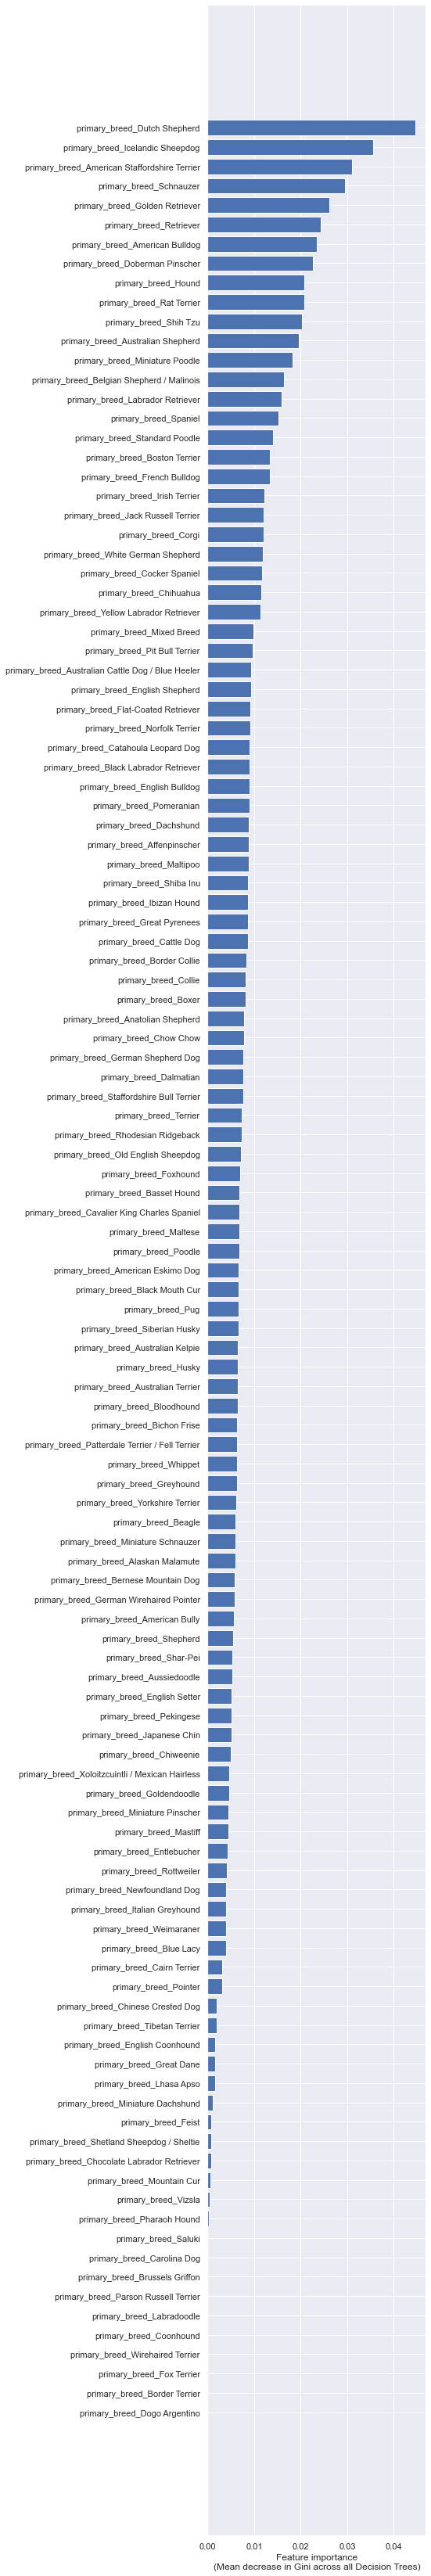

In [166]:
sns.set()
plot_feat_import(x_feat_list_breeds, feature_importances)

In [167]:
px.bar(x=x_feat_list_breeds, y=feature_importances).update_xaxes(categoryorder='total descending')

### Test 3 - Only Looking at Colors

In [168]:
x_feat_list_colors = ['primary_color_Apricot / Beige', 
                       'primary_color_Bicolor', 'primary_color_Black', 'primary_color_Brindle', 'primary_color_Brown / Chocolate', 
                       'primary_color_Golden', 'primary_color_Gray / Blue / Silver', 'primary_color_Harlequin', 
                       'primary_color_Merle (Blue)', 'primary_color_Merle (Red)', 'primary_color_Red / Chestnut / Orange', 
                       'primary_color_Sable', 'primary_color_Tricolor (Brown, Black, & White)', 'primary_color_White / Cream', 
                       'primary_color_Yellow / Tan / Blond / Fawn']
feature_importances, feat_import_dict, r2, mse, residuals  = random_forest_regress_default(x_feat_list=x_feat_list_colors, y_col='delta_time_minutes', df=dogs_df_dummies)
print(f'''R2: {r2}, MSE: {mse}''')

R2: -0.004324249430478044, MSE: 233992.1736445139


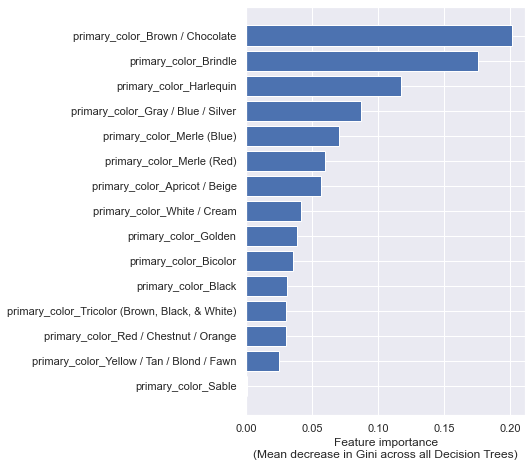

In [169]:
sns.set()
plot_feat_import(x_feat_list_colors, feature_importances)

In [170]:
px.bar(x=x_feat_list_colors, y=feature_importances).update_xaxes(categoryorder='total descending')

### Test 4 - Only Looking at Features not Including Colors or Breeds

In [171]:
x_feat_list_nobreed_nocolor = ['compatible_children', 'compatible_dogs', 'compatible_cats', 
               'age_Adult', 'age_Baby', 'age_Senior', 'age_Young', 'gender_Female', 'gender_Male', 
               'size_Extra Large', 'size_Large', 'size_Medium', 'size_Small', 'coat_Curly', 'coat_Hairless', 
               'coat_Long', 'coat_Medium', 'coat_Short', 'coat_Wire']
feature_importances, feat_import_dict, r2, mse, residuals  = random_forest_regress_default(x_feat_list=x_feat_list_nobreed_nocolor, y_col='delta_time_minutes', df=dogs_df_dummies)
print(f'''R2: {r2}, MSE: {mse}''')

R2: -0.13790514334441428, MSE: 265114.47676725936


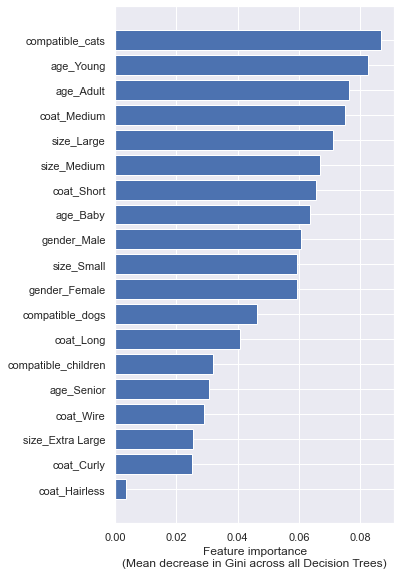

In [172]:
sns.set()
plot_feat_import(x_feat_list_nobreed_nocolor, feature_importances)

In [173]:
px.bar(x=x_feat_list_nobreed_nocolor, y=feature_importances).update_xaxes(categoryorder='total descending')